In [1]:
# 데이터를 저장할 폴더 생성
!mkdir data

In [2]:
# Content이미지와 Style이미지를 PIL 이미지 객체로 불러오기
from PIL import Image
path2content = "./data/content.jpg" # 김유정 이미지
path2style = "./data/style.jpg" # 물감 이미지

content_img = Image.open(path2content)
style_img = Image.open(path2style)

In [3]:
# 이미지 데이터 Pre-processor 정의하기
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.5,0.5,0.5)
std_rgb = (0.5,0.5,0.5)

# 이런 전처리기는 PIL 이미지 객체에 대해서도 사용할 수 있다
transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)
])

# 전처리된 PIL 이미지 객체
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)

# 전처리된 PIL파일의 shape 및 Gradient 미분 값 저장 여부 출력
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


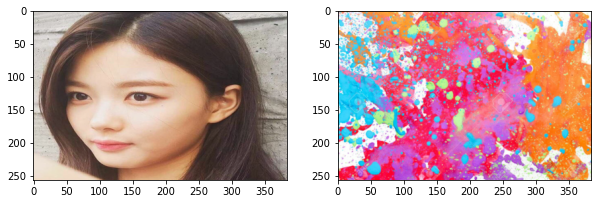

In [32]:
# Transformation이 적용된 Image를 시각화 한다

import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image
# transformation이 적용된 image 시각화하기
import torch

# Tensor 이미지를 입력받아서 (channel, height, width)
# 각 픽셀에 Standard Deviation을 곱하고 Mean값을 더해준다
# 데이터가 전처리기에 의하여 Standardized되었기 때문에 이를 그대로 출력하면 이상한 이미지가 출력된다.
# 그래서 반대로 De-Standardized 해 주는 것이다.

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1) # 모든 pixel값이 0과 1 사이에 위치하도록 clamping 실시
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))    

In [23]:
# Style Transfer를 구현하기
# Pre-trained VGG19를 불러와서 content Image와 Style Image의 Feature를 추출한다
import torchvision.models as models

# Device 정의 / cuda 혹은 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VGG-19 model
# Evaluation model로 변경
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

# VGG-19 모델의 tuning없이 진행할 예정이므로, 가중치 계산이 불필요하여 다음과 같이 False로 설정하였다
for param in model_vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# style loss와 content loss를 정의하기 위하여
# model의 중간 중간 feature map에서의 Gram matrix를 계산해야 한다

# 모델의 중간 Layer의 출력 Feature map을 얻는 함수를 정의한다
# 총 여섯 개의 Layer가 존재한다
# 각 Layer의 출력인 6개의 feature map이 출력된다
def get_features(x, model, layers):
  features = {}
  for index, layer in enumerate(model.children()):
    x = layer(x)
    if str(index) in layers:
      features[layers[str(index)]] =  x
  return features

In [7]:
# Gram matrix계산하는 함수를 정의하기
# style loss를 계산할 때 필요하다
# 특정 feature map의 channel간 correlation정보를 담아 중요한 상관관계 값을 찾는 것이다
def gram_matrix(x):
  n, c, h, w = x.size() # batch_size, channel, height, width
  x = x.view(n*c, h*w)
  gram = torch.mm(x, x.t()) # 
  return gram


In [8]:
# content_loss를 계산하는 함수를 정의한다
# input tensor와 content tensor가  각각 VGG-19 model의 맨 마지막 layer를 통과했을 때 나오는 
# feature map끼리의 MSELoss를 계산한다
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
  target = target_features[layer]
  pred = pred_features[layer]
  loss = F.mse_loss(pred, target)
  return loss

In [30]:
# style_loss를 계산하는 함수를 정의한다
# input_tensor, style_tensor를 모델에 넣은 후 나온 feature map들 중에서
# 총 다섯 쌍의 feature map의 gram_matrix를 구하고
# 서로 대응하는 feature map간의 gram_matrix의 차이가 없도록 학습하는 것이 목표이다

def get_style_loss(pred_features, target_features, style_layers_dict):
  loss = 0
  for layer in style_layers_dict:
    pred_fea = pred_features[layer]
    pred_gram = gram_matrix(pred_fea)
    n,c,h,w = pred_fea.shape
    target_gram = gram_matrix(target_features[layer])
    layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
    loss += layer_loss / (n*c*h*w)
  return loss

In [24]:
# pre-trained VGG19를 사용하여 content와 style image의 feature추출한다
# VGG-19의 각 Layer이름이다
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

# pytorch의 모든 모델은 입력을 4차원으로 받으므로
# 3차원 이미지에 batch dimension을 추가해준다
con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

# content_tensor를 model_vgg에 입력시킨 후 
# 총 여섯 개의 중간 feature map을 출력한다
content_features = get_features(con_tensor, model_vgg, feature_layers)

# style_tensor를 model_vgg에 입력시킨 후 
# 총 여섯 개의 중간 feature map을 출력한다
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [25]:
# 추출된 feature map의 shape를 확인해보자
for key in content_features.keys():
  print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


In [26]:
# Optimizer 정의하기
# input tensor는 content image를 복사하여 생성하고
# optimizer는 input_tensor의 pixel값들을 서서히 변경해나갈 것이다
# 학습이 진행
input_tensor = con_tensor.clone().requires_grad_(True)

# optimizer 정의하기
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

In [33]:
# 이미지 합성하기
# style_layers_dict는 5개의 conv layer에서 출력되는 style image의 특징들에 대한 가중치 정보가 있다

# Hyper Parameter정의하기
num_epochs = 300
content_weight = 1e1
style_weight = 1e4
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}

# style Transfering
for epoch in range(num_epochs+1):
  optimizer.zero_grad()

  # input tensor를 VGG19 모델에 입력한 후 각 계층으로부터의 feature map 6개를 출력한다
  input_features = get_features(input_tensor, model_vgg, feature_layers)

  # input image tensor와 content image tensor를 넣었을 때 나오는 최종 출력 feature map끼리 비교하여 content_loss를 출력한다
  content_loss = get_content_loss(input_features, content_features, content_layer)

  # input image tensor와 content image tensor의 feature mapt들 중
  # 총 다섯 개 feature map의 gram_matrix의 차이가 없도록 한다
  style_loss = get_style_loss(input_features, style_features, style_layers_dict)

  # 총 손실함수
  neural_loss = content_weight * content_loss + style_weight * style_loss
  neural_loss.backward(retain_graph=True)
  optimizer.step()
  if epoch % 2 == 0:
    print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))  

epoch 0, content loss: 2.3, style loss: 2.1e+01
epoch 2, content loss: 2.3, style loss: 2e+01
epoch 4, content loss: 2.3, style loss: 1.9e+01
epoch 6, content loss: 2.3, style loss: 1.8e+01
epoch 8, content loss: 2.3, style loss: 1.8e+01
epoch 10, content loss: 2.3, style loss: 1.7e+01
epoch 12, content loss: 2.3, style loss: 1.6e+01
epoch 14, content loss: 2.3, style loss: 1.6e+01
epoch 16, content loss: 2.3, style loss: 1.5e+01
epoch 18, content loss: 2.3, style loss: 1.5e+01
epoch 20, content loss: 2.3, style loss: 1.4e+01
epoch 22, content loss: 2.3, style loss: 1.4e+01
epoch 24, content loss: 2.3, style loss: 1.3e+01
epoch 26, content loss: 2.3, style loss: 1.3e+01
epoch 28, content loss: 2.3, style loss: 1.2e+01
epoch 30, content loss: 2.3, style loss: 1.2e+01
epoch 32, content loss: 2.3, style loss: 1.1e+01
epoch 34, content loss: 2.4, style loss: 1.1e+01
epoch 36, content loss: 2.4, style loss: 1.1e+01
epoch 38, content loss: 2.4, style loss: 1e+01
epoch 40, content loss: 2.4, 

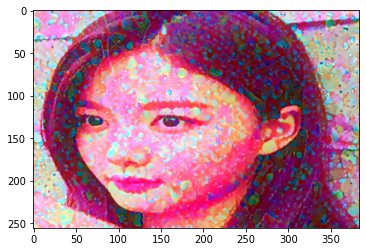

In [34]:
# 결과 시각화
# matplotlib을 이용한 시각화를 할 때 반드시 cuda에서 CPU로 이동해주어야 한다
# 현재 input_tensor는 4차원이기 때문에 다음과 같이 input_tensor[0]으로  출력한다
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))